In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

# Project 1
Due March 12, 2019.

For the midterm project, you will develop a Tolman-Oppenheimer-Volkov (TOV) solver to compute the hydrostatic structure of a relativistic neutron star. You will use this to determine the maximum masses of cold neutron stars (NSs) for several different equations of state (EOS).

Your code should adhere to the course Coding Standards.

  - Write a numerical solver for the spherically-symmetric TOV equations using a fourth-order Runge-Kutta integrator. Assume a polytropic EOS specified by $K$ and $\gamma$. You may find these notes particularly helpful.
  
\begin{align}
\frac{dm}{dr} &= 4\pi r^2 \rho \\
\frac{dP}{dr} &= -\frac{\rho m }{r^2}\left ( 1 + \frac{P}{\rho}\right ) \left( 1 + \frac{4\pi P^3}{m} \right ) \left ( 1 - \frac{2m}{r}\right ) ^{-1}\\
\frac{d\Phi}{dr} &= - \frac{1}{\rho} \frac{dP}{dr}\left( 1 + \frac{P}{\rho}\right ) ^{-1}
\end{align}

For a polytropic eos: $P = K \rho_0^\Gamma$, where $K$ is the polytropic gas constant and $n$ defined by $\Gamma \equiv 1 + 1/n$ is the polytropic index. We then have   $\rho = \rho_0 + P/(\Gamma -1 )$  and $\rho_0 \epsilon = P/(\Gamma -1 )$.
   
Below, constants are the corresponding barred ones.

In [2]:
from tov import *

4.0657581468206416e-20
-1.3552527156068805e-20
-4.743384504624082e-20
6.776263578034403e-21
6.776263578034403e-21
1.0164395367051604e-19
0.0
-4.0657581468206416e-20
-5.421010862427522e-20
5.421010862427522e-20
0.16144896407401682


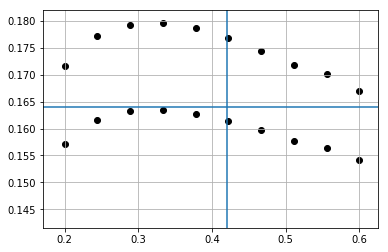

In [5]:
test_star = PolytropeStar(gamma = 2)
integrator = 'dopri5'

for rhoc_bar in np.linspace(0.2, 0.6, 10):
    test_star.set_initial_conditions(rhoc = rhoc_bar)
    solver =  test_star.solve_star(integrator = integrator)
    print(solver.y[1][-1])
    plt.scatter(rhoc_bar, solver.y[0][-1], c='k')
    plt.scatter(rhoc_bar, solver.y[3][-1], c='k')
solver = test_star.set_initial_conditions(rhoc = 0.420).solve_star(
                    integrator = integrator)
print(solver.y[0][-1])
plt.axvline(0.42)
plt.axhline(0.164)
plt.grid()

In [6]:
n = 4/7
gamma = 1+1/n
print(gamma)

K = 30000 # in c = G = M_sun = 1

2.75


    
  - Determine the maximum mass of a cold NS for $K=30000$ (in $G=c=M_\odot=1$ units) and $\gamma=2.75$.
 

In [7]:
gamma = 2.75
n = 1/(gamma - 1)

values = []

N = 200
for rhoc_bar in np.linspace(0.1, 1.8, N):
    test_star = PolytropeStar(gamma).set_initial_conditions(rhoc = rhoc_bar)
    solver = test_star.solve_star()

    r = solver.t
    M, P, Phi, M0 = solver.y
    values.append([r[-1], M[-1], P[-1], Phi[-1], M0[-1], rhoc_bar])
   

<IPython.core.display.Math object>


Maximum values for K = 30000, \gamma = 2.75:
     M_bar = 0.128
     R     = 11.94  km
     M     = 2.434 M_sun   
     M_0   = 2.896 M_sun     
     rho_c = 1.395e+15 g/cc      



Text(0.5,0,'Central density [g/cc]')

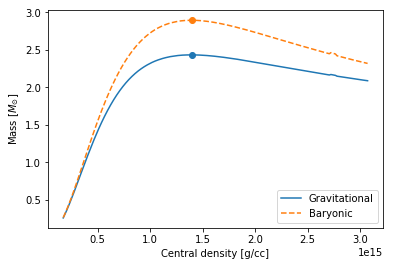

In [8]:
K     = 30000      # C = G = M_sun = 1
K_cgs = 1.98183e-6 # cgs
 
radius, grav_mass, pressure, _, mass, rhoc_bar = np.array(values).T
imax = np.argmax(grav_mass)

M_max_sun = grav_mass[imax] * K**(n/2)

length_conv  = 6.7706e-6
density_conv = 1.6199e-18
rhoc_cgs = rhoc_bar * K**(-n)/density_conv
r_km     = radius * K**(n/2)/length_conv * 1e-5

from IPython.display import display, Latex, Math
display(Math("Ax=b"))

disp_string = r"""
Maximum values for K = 30000, \gamma = 2.75:
     M_bar = {mbar:.3f}
     R     = {r:.4g}  km
     M     = {gm:.3f} M_sun   
     M_0   = {bm:.3f} M_sun     
     rho_c = {cd:.4g} g/cc      
""".format(mbar = grav_mass[imax], r =  r_km[imax],
           gm =  grav_mass[imax] * K**(n/2),
           bm =  mass[imax] * K**(n/2), cd =  rhoc_cgs[imax])

print(disp_string)

plt.scatter(rhoc_cgs[imax], grav_mass[imax] * K**(n/2), c = 'C0')
plt.scatter(rhoc_cgs[imax], mass[imax]* K**(n/2), c = 'C1')

plt.plot(rhoc_cgs, grav_mass* K**(n/2), '-', label = 'Gravitational')
plt.plot(rhoc_cgs, mass* K**(n/2), '--', label = 'Baryonic')
plt.legend()
plt.ylabel('Mass [$M_{\odot}$]')
plt.xlabel('Central density [g/cc]')

 
  - Now, modify your code to use any arbitrary table-based EOS. Specifically, make your solver compatible with the EOS available on stellarcollapse.org. There is example code on that site in C++ and Fortran for reading and using the tables there, and working with the EOS tables is trivial in Python using h5py.
 

Loading the HShen, there are some weird things with the temperature ranges of this one

In [9]:
import h5py

test = 'HShen_HyperonEOS_rho220_temp180_ye65_version_1.1_20131007.h5'
ftest = h5py.File(test)
print(list(ftest.keys()))


['Abar', 'Meff', 'Xa', 'Xh', 'Xn', 'Xp', 'Zbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'timestamp', 'ye']


/home/halvard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
print('log', get_bounds(ftest['logrho'][:]),   'g/cm^3')
print('log', get_bounds(ftest['logpress'][:]), 'MeV/fm^3')
print('log', get_bounds(ftest['ye'][:]))

NameError: name 'get_bounds' is not defined

There are 
Table structures:
 - Temperature  
$T$[MeV]$: -1.0\leq \log_{10}(T) \leq 2.6$; mesh of $\log_{10}(T) = 0.04$
 - Proton fraction  
$Y_p: 0.01 \leq Y_p \leq 0.65$; mesh of $Y_p= 0.01$
 - Baryon mass density   
$\rho_B$[g/cm3]$: 5.1 \leq \log_{10}(\rho_B) \leq 16.0$; mesh of $\log_{10}(\rho_B) = 0.1$

In [14]:
filename = 'Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5'

In [15]:
f = h5py.File(filename, 'r')
keys = list(f.keys())
print(keys)

['Abar', 'X3he', 'X4li', 'Xa', 'Xd', 'Xh', 'Xn', 'Xp', 'Xt', 'Zbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'timestamp', 'ye']


# Figuring out the units

In [16]:
def get_bounds(x):
    return [np.min(x), np.max(x)]

In [17]:
print('log', get_bounds(f['logrho'][:]),   'g/cm^3')
print('log', get_bounds(f['logpress'][:]), 'MeV/fm^3')
# print(get_bounds(f['log'][:]))

log [2.2202492, 15.500249] g/cm^3
log [18.012309853651733, 36.70818475697236] MeV/fm^3


In [18]:
g_cm3 = 1.6199e-18
g_cm3

1.6199e-18

In [19]:
from scipy.constants import erg, eV
5.5953e-55 * erg / eV * 1e-6 # MeV
a = 1 # MeV 
a * 1e6 * eV / erg #* 5.5953e-55 # correct units

1.6021766208000002e-06

In [20]:
MeVfm3 = 1.6021766e33 # dyne/cm2
MeVfm3 = 1.6021766e33 * 1.8063e-39
dyne_cm2 = 1
# dyne_cm2_to_cgmsun = 1.8063e-39 * 1/1.6022e33
dyne_cm2 * 1.8063e-39

1.8063e-39

In [21]:
j

NameError: name 'j' is not defined

In [22]:
from scipy.interpolate import (interp1d, interp2d, 
                               griddata, BivariateSpline, 
                               LinearNDInterpolator)
from scipy import optimize

class TableStar(BaseStar):
    def __init__(self, tablefile, scaling = {}, *args, **kwargs):
        """Assumes cold star, i.e minimal T. 
        
        Scales to geometrized units c = G = M_sun = 1
        
        TODO:
        convert the following from log to linear:
            rho, pres, energy, munu?, 
        """
        BaseStar.__init__(self, *args, **kwargs)
        f = h5py.File(tablefile, 'r')
        self.file = f
        
        self.scaling = {}
        
        # default scaling is  c = G = M_sun = 1
        default_scaling = {'pres'  : 1.8063e-39, # from dyn/cm^2
                           'rho'   : 1.6199e-18, # from g/cm^3
                           'energy': 1.11265005605e-21,  # from erg/g
                           'munu'  : 8.96465885e-61 # from MeV
                           # munu should be MeV/baryon
                          }
        default_scaling.update(scaling)
        self.update_scaling(default_scaling)
        
        # self.T_ind = 0
        self.ye_arr   = f['ye'][:] 
        self.rho_arr  = f['logrho'][:] + np.log10(self.scaling['rho'])
        # temp_arr = f['logtemp'][:]
        
        self.energy_shift  = f['energy_shift'][0] * self.scaling['energy']

        rho_grid, ye_grid  = np.meshgrid(self.rho_arr, self.ye_arr)
        pres_values   = f['logpress'][:,0,:]  + np.log10(self.scaling['pres'])
        munu_values   = f['munu'][:,0,:]      *          self.scaling['energy']
        energy_values = f['logenergy'][:,0,:] + np.log10(self.scaling['energy'])
        
        self.ye_bounds   = (np.min(self.ye_arr),  np.max(self.ye_arr))
        self.rho_bounds  = (np.min(self.rho_arr), np.max(self.rho_arr))
        self.pres_bounds = (np.min(pres_values),  np.max(pres_values))
        

        ye_pres_points = np.column_stack([ye_grid.ravel(), pres_values.ravel()]),
        ye_rho_points  = np.column_stack([ye_grid.ravel(), rho_grid.ravel()]),
        
            
        self.rho_interp       = LinearNDInterpolator(ye_pres_points, rho_grid.ravel(), 
                                                     fill_value = np.inf)
        self.pres_interp      = LinearNDInterpolator(ye_rho_points, pres_values.ravel(),
                                                    fill_value = np.inf)
        self.energy_interp    = LinearNDInterpolator(ye_rho_points, energy_values.ravel(),
                                                    fill_value = np.inf)
        self.munu_interp_rho  = LinearNDInterpolator(ye_rho_points, munu_values.ravel(),
                                                    fill_value = np.inf)
        self.munu_interp_pres = LinearNDInterpolator(ye_pres_points, munu_values.ravel(),
                                                    fill_value = np.inf)
        
        # self.rho_interp_lin_scaled = lambda points: rho_scale*10**self.rho_interp(points)
        
    def update_scaling(self, new_scaling):
        """update scaling constant dict.
        
        Original units:
        rho:    g/cm3   
        pres:   MeV/fm3
        energy: MeV
        munu':  MeV
        """
        self.scaling.update(new_scaling) 
        
    def check_in_bounds(self, val, val_type):
        if val_type == 'rho':
            bounds = self.rho_bounds
        elif val_type == 'pres':
            bounds = self.pres_bounds
        elif val_type == 'ye':
            bounds = self.ye_bounds
        else:
            raise ValueError('Invalid val_type, %s' %val_type)
        if not ((val < bounds[1]) and (val > bounds[0])):
            raise ValueError("Value '%s' out of bounds. %.3f not in interval [%.3f, %.2f]" % (val_type, val, bounds[0], bounds[1]))
        
        
    def energy(self, ye, rho):
        logrho = np.log10(rho)
        return 10**self.energy_interp(ye, logrho) - self.energy_shift
    
        
    def munu(self, ye, val, val_type):
        """Returns value of munu either from pressure or from density, based on val_type argument"""
        self.check_in_bounds(val, val_type)
        if val_type == 'rho':
            return self.munu_interp_rho([ye, val])[0]
        elif val_type == 'pres':
            return self.munu_interp_pres([ye, val])[0]
        else:
            raise ValueError("val_type must be either 'rho' or 'pres'")
        
    def P(self, rho):
        a, b = self.ye_bounds
        logrho = np.log10(rho)
        res = optimize.bisect(self.munu, a = a, b = b, args=(logrho, 'rho'), )
                                   #method = 'brentq', bracket = self.ye_bounds)
        self.current_ye = res
        return 10**self.pres_interp(self.current_ye, logrho)
    
    def rho(self, P):
        a, b = self.ye_bounds
        logP = np.log10(P)
        res = optimize.bisect(self.munu, a = a, b = b,  args=(logP, 'pres'), )
                                   #method = 'brentq',bracket = self.ye_bounds)
        self.current_ye = res
        return 10**self.rho_interp(self.current_ye, logP)
    
    def rho0(self, P, rho = None):
        """Uses P as is, no convert to log"""
        rho = rho or self.rho(P)
        eps = self.energy(self.current_ye, rho)
        return rho / (1 + eps)
    
    def get_pressure_event(self):
        """Passed to solver for termination when is pressure 0."""
        def pressure_event(t, y):
            print(y)
            if np.isnan(y[1]):
                return -1
            else:
                return y[1] # - 10**self.pres_bounds[0]
        pressure_event.terminal = True
        return pressure_event



In [32]:
rhoc = 3e15 * 1.6199e-18
test = TableStar(filename).set_initial_conditions(rhoc = rhoc)
solver = test.solve_star()

plt.plot(solver.t)#, solver.y[1])

/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in log10


ValueError: Value 'pres' out of bounds. nan not in interval [-20.731, -2.07]

-15.570262594586174 -2.290262794586173
-3.0


/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in log10


ValueError: Value 'pres' out of bounds. nan not in interval [-20.731, -2.07]

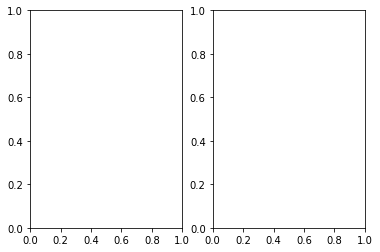

In [31]:
fig,[ax1,ax2] = plt.subplots(1,2)
star = TableStar(filename)

final_values = []

a,b = star.rho_bounds
print(a,b)
for logrhoc in np.linspace(-3, -2.2903, 10):
    print(logrhoc)
    star.set_initial_conditions(rhoc = 10**logrhoc)
    solve = star.solve_star()
    
    last_pos = np.sum(solve.y[1] > 0) - 1 # assumes strictly decreasing values. -1 for python indexing
    final_values.append([logrhoc, solve.t[last_pos]] + list(solve.y[:,last_pos]))
    
    ax1.semilogy(solve.t, solve.y[1], label = 'logrhoc {:.2f}'.format(logrhoc))
    ax2.scatter(logrhoc, solve.y[0,last_pos])
ax1.legend()
# rhoc = 3e15 * 1.6199e-18
# test = TableStar(filename).set_initial_conditions(rhoc = rhoc)

In [191]:
rho, r_values, m_values, P_values, phi_values, M0_values = np.array(final_values).T
print(star.r_max)

33.853


In [176]:
P_values

array([5.00567424e-20, 1.49291100e-18, 1.29788944e-16, 9.37959313e-15,
       4.87749487e-13, 2.19025227e-11, 7.59160655e-10, 1.79582252e-09,
       3.23005987e-10, 4.85621444e-05])

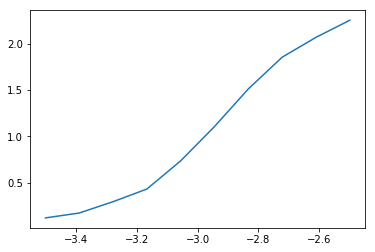

In [195]:
plt.plot(rho, m_values)

In [100]:
np.log10(3e15 * 1.6199e-18)

-2.3133905398665093

In [31]:
rho_arr = test.rho_arr
np.min(rho_arr)

-15.570262594586174

In [29]:
a, b  = test.ye_bounds
print(test.pres_bounds)
print(test.rho_bounds)
test.pres_interp(a, -15), test.pres_interp(b, -13)

(12.473816462979027, 31.137494898576243)
(-15.570262594586174, -2.290262794586173)


(array(13.26096477), array(15.27115674))

In [179]:
test.ye_bounds

[0.01, 0.6]

In [217]:
test.P(test.rhoc)
[(test.P(v),v) for v in np.logspace(-10,1,11)]

0.10213750610733767
0.45443184038014806
0.43409960651863005
0.40083482095398715
0.3503793651735577
0.1216195568156945
0.021374249984201014
0.05000477502520881
0.1026683613960085


ValueError: f(a) and f(b) must have different signs

array([[-2.45769699e+01, -2.45755862e+01, -2.45742025e+01, ...,
        -3.02907933e+02, -3.33202025e+02, -3.63468616e+02],
       [-2.45645344e+01, -2.45630740e+01, -2.45616135e+01, ...,
        -3.02907936e+02, -3.33202027e+02, -3.63468618e+02],
       [-2.45514582e+01, -2.45499167e+01, -2.45483751e+01, ...,
        -3.02907939e+02, -3.33202030e+02, -3.63468620e+02],
       ...,
       [-1.06340266e-03, -1.06340305e-03, -1.06340346e-03, ...,
        -5.92996414e+02, -6.16716341e+02, -6.42824687e+02],
       [-9.30952766e-04, -9.30953142e-04, -9.30953546e-04, ...,
        -5.86696148e+02, -6.11332327e+02, -6.38396449e+02],
       [-8.42943435e-04, -8.42943803e-04, -8.42944195e-04, ...,
        -5.78928416e+02, -6.04529721e+02, -6.32577906e+02]])

In [80]:
test.solve_star()

nan
nan
nan
nan
0.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [ ]:
T_arr = np.array(f['logtemp'])
ye_arr = np.array(f['ye'])
rho_arr = np.array(f['logrho'])

rho_grid, ye_grid = np.meshgrid(rho_arr, ye_arr)
pres_values = f['logpress'][:,0,:]
munu_values = f['munu'][:,0,:]


ye_pres_points = np.column_stack([ye_grid.ravel(), pres_values.ravel()]),
ye_rho_points  = np.column_stack([ye_grid.ravel(), rho_grid.ravel()]),

rho_interp  = LinearNDInterpolator(ye_pres_points, rho_grid.ravel())
pres_interp = LinearNDInterpolator(ye_rho_points, pres_values.ravel())
munu_interp = LinearNDInterpolator(ye_rho_points, munu_values.ravel())

In [59]:
func3 = lambda ye, P : munu_interp([ye, P])
ye_bounds = [np.min(ye_arr), np.max(ye_arr)]
res = optimize.root_scalar(func3, method = 'brentq', args=(P), bracket = ye_bounds)
res

      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 0.4006215563522918

In [36]:
? optimize.fsolve

'1.0.0'

In [ ]:
rho_interp = interp2d(ye_grid, pres_values, rho_grid)

pres_interp = interp2d(ye_grid, rho_grid, pres_values)

In [78]:
# rho_interp(0.4, 20)
pres_interp([0.4, 0.7], [4, 5])

array([[19.59639979, 19.89543038],
       [20.7472737 , 21.086524  ]])

In [79]:
?pres_interp

In [61]:
a = pres_interp(ye_grid.ravel(), pres_values.ravel())

In [62]:
np.isclose(a, pres_values)

ValueError: operands could not be broadcast together with shapes (13320,13320) (60,222) 

In [56]:
rho_interp(0.4, 20)

array([4.38147034])

In [49]:
%timeit rho_interp(0.4, 20)

16.8 µs ± 206 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


array([4.38147034])

In [17]:
rho_shaped = rho_values.reshape(pres_grid.shape)

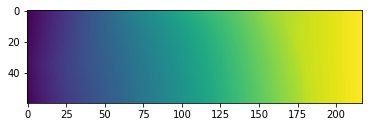

In [19]:
valid_cols = ~np.any(np.isnan(rho_values.reshape(pres_grid.shape)), axis = 0)
rho_valid = rho_shaped[:,valid_cols]

plt.imshow(rho_shaped[:,valid_cols])

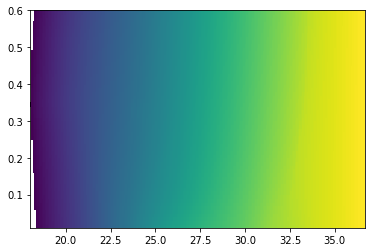

In [20]:
grid_reshaped = grid.reshape(list(pres_grid.shape)+[-1])
plt.pcolormesh(grid_reshaped[:,:,0], grid_reshaped[:,:,1], rho_shaped)

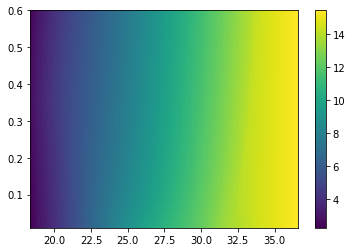

In [21]:
grid_valid = grid_reshaped[:,valid_cols]
m = plt.pcolormesh(grid_valid[:,:,0], grid_valid[:,:,1], rho_valid)
plt.colorbar(m)

In [23]:
grid_valid = grid_reshaped[:,valid_cols]

In [25]:
grid_valid.shape, rho_valid.shape

((60, 217, 2), (60, 217))

In [31]:
sdalsadj

(60, 222, 2)

In [26]:
? interp2d

In [ ]:
rho_interp = interp2d(grid_reshaped[:,valid_cols,0].ravel(), 
                           grid_reshaped[:,valid_cols,1].ravel(), 
                           rho_valid.ravel())

In [ ]:
grid.shape
np.any(np.isnan(rho_values))

In [ ]:
pressure_interp(grid.T[0], grid.T[1])

In [ ]:
Nrho, Ntemp, Nye, pres_values.shape

In [ ]:
m = plt.scatter(ye_grid.ravel(), rho_grid.ravel(), c = pres_values.ravel())
plt.colorbar(m)

In [ ]:
m = plt.scatter(grid.T[0], grid.T[1], marker='.', c = rho_values)
plt.colorbar(m)

In [ ]:
from scipy.interpolate import griddata

pressure_grid = np.linspace(np.min(a), np.max(a), N)
P,_b = np.meshgrid(pressure_grid, b)

print(P.shape)
points = np.array([A.ravel(), c.ravel()]).T
values = B.ravel()
xi = np.array([A.ravel(), c.ravel()]).T

print(B.size, c.size, A.size)
print(points.shape)

gd = griddata(points, values, xi) 
plt.pcolormesh(points[:,0], points[:,1], gd)

In [ ]:
np.concatenate([A.ravel(),B.ravel()])

In [ ]:
np.array(f['logrho'])

 
  - Determine the maximum mass for any five of the EOS available on stellarcollapse.org.
 

 
  - Make mass vs. radius plots for these same five EOS.